Import python libraries:

In [115]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import config as cfg
from alpaca.trading import TradingClient
from alpaca.trading.stream import TradingStream
from alpaca.trading import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

from scipy.interpolate import UnivariateSpline

Define function to pull ticker price history:

In [116]:
def get_ticker_history(ticker):

    stock = yf.Ticker(ticker)
    stock.info
    history = stock.history(period="1mo")

    df = pd.DataFrame(history)
    df.reset_index(inplace=True)
    
    #drop unwanted columns
    df.drop(['High','Low','Dividends','Stock Splits'], axis=1, inplace=True)

    #rename columns
    df.rename(columns={'Open': 'open_price', 'Close': 'close_price', 'Volume': 'volume'}, inplace=True)

    #clean up columns
    df['open_price'] = np.round(df['open_price'],2)
    df['close_price'] = np.round(df['close_price'],2)
    df['date_numeric'] = df.index + 1
    df['date'] = (df['Date']).dt.date

    #calculate new columns
    df['ticker'] = f'{ticker}'
    df['price_delta'] = df['close_price'] - df['open_price']

    #return desired columns
    df = df[['ticker', 'open_price', 'close_price', 'price_delta', 'date', 'date_numeric']]

    return(df)

Print the first few rows of our dataframe:

In [117]:
ex_table = get_ticker_history("NVDA")
print(ex_table.head(5))

  ticker  open_price  close_price  price_delta        date  date_numeric
0   NVDA      680.03       674.69        -5.34  2024-02-21             1
1   NVDA      750.21       785.34        35.13  2024-02-22             2
2   NVDA      807.86       788.13       -19.73  2024-02-23             3
3   NVDA      796.96       790.88        -6.08  2024-02-26             4
4   NVDA      793.77       786.97        -6.80  2024-02-27             5


Plot the data in our dataframe:

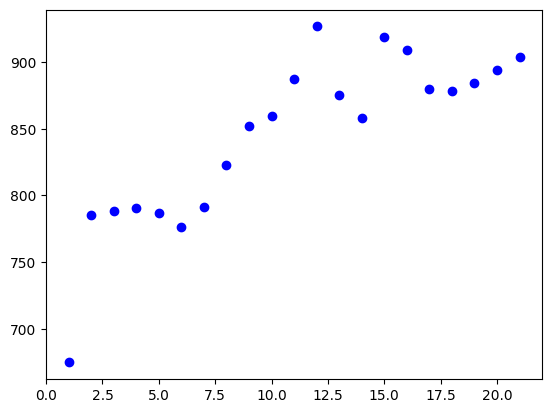

In [118]:
df = get_ticker_history("NVDA")
plt.scatter(df['date_numeric'], df['close_price'], label='Original Data', color='blue')
plt.show()

Here's what the fitted curve looks like visually:

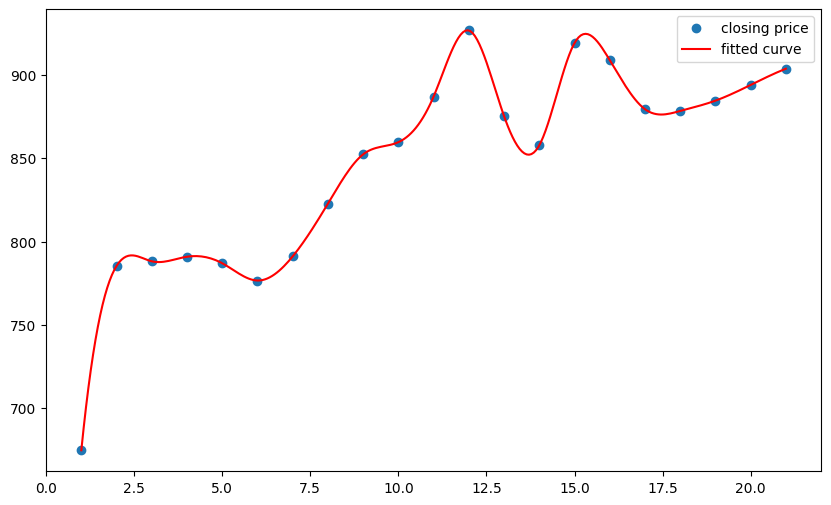

In [119]:
df = get_ticker_history("NVDA")

x = df['date_numeric']
y = df['close_price']

spline = UnivariateSpline(x, y, s=0, k=3)

x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x_smooth)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='closing price')  # Original data points
plt.plot(x_smooth, y_smooth, '-', label='fitted curve', color='red')  # Smooth curve
plt.legend()
plt.show()

Create a new function to calculate the 2nd derivative of fitted curve at each closing price:

In [120]:
def calculate_d2ydx2(ticker):
    
    df = get_ticker_history(ticker)
    spline = UnivariateSpline(df['date_numeric'], df['close_price'], s=0, k=3)
    df['d2ydx2'] = spline.derivative(n=2)(df['date_numeric'])    
    df = (df[['ticker','date','close_price','d2ydx2','date_numeric']])

    return(df)

Now we've got the 2nd derivative at each closing price:

In [121]:
ex_table = calculate_d2ydx2("NVDA")
ex_table = ex_table.sort_values(by='date_numeric', ascending=False)

print(ex_table.head(5))

   ticker        date  close_price     d2ydx2  date_numeric
20   NVDA  2024-03-20       903.72  -4.532916            21
19   NVDA  2024-03-19       893.98   0.310000            20
18   NVDA  2024-03-18       884.55   5.152916            19
17   NVDA  2024-03-15       878.37  -1.421665            18
16   NVDA  2024-03-14       879.44  44.033743            17


Generate a buy or sell signal based on the current second derivative in the function:

In [122]:
def generate_signal(ticker):

    df = calculate_d2ydx2(ticker)
    date_current = df['date_numeric'].max()

    result = df.loc[df['date_numeric'] == date_current, 'd2ydx2'].item()

    if result > 0:
        return 1 #buy
    else:
        return 0 #sell

Test our function:

In [123]:
generate_signal('NVDA')

0

(If the most recent d2ydx2 is negative, we expect a sell signal, vice versa)

Create trading function to trade user's tickers:

In [124]:
def qualify_tickers(tickers):
    
    input_tickers = tickers
    ticker_df = pd.DataFrame(columns=['ticker','signal'])

    for i in input_tickers:
        
        signal = generate_signal(i)

        new_row = {'ticker': i, 'signal': signal}
        ticker_df = pd.concat([ticker_df, pd.DataFrame([new_row])], ignore_index=True)

    return(ticker_df)

In [125]:
ex_tickers = ['NVDA','MSFT','GME','AMD','TSM','AAPL'] 

result_df = qualify_tickers(ex_tickers)
print(result_df)

  ticker signal
0   NVDA      0
1   MSFT      1
2    GME      1
3    AMD      1
4    TSM      1
5   AAPL      0


Now we can generate buy or sell signals from a user's input list, but we need to connect to a platform's API to place buy and sell orders.

In [126]:
api_key = cfg.api_key
secret_key = cfg.secret_key
base_url = cfg.base_url

trading_client = TradingClient(api_key, secret_key, paper=True)

# test client connection
#acc = dict(trading_client.get_account())
#for k,v in acc.items():
#    print(k,v)


In [128]:
user_input = ['NVDA','MSFT','GME','TSM','AAPL','GOOG']

api_key = cfg.api_key
secret_key = cfg.secret_key

trades = TradingStream(api_key, secret_key, paper=True)

def trade_tickers(tickers):
    
    # get current positions in case we need to sell / don't buy anything we already have a current position in
    
    current_positions = trading_client.get_all_positions()
    positions = pd.DataFrame(current_positions)
    print('current positions: \n',positions)

    algo_df = qualify_tickers(tickers)

    order_dollars = 2500

    for row in algo_df.itertuples(index=False):

        ticker_symbol = row.ticker
        ticker_signal = row.signal

        # place a buy order if signal is a buy signal
        if ticker_signal == 1: 
            
            market_order_data = MarketOrderRequest(
                symbol = ticker_symbol,
                notional = order_dollars,
                side=OrderSide.BUY,
                time_in_force=TimeInForce.DAY
            )
            
            trading_client.submit_order(
                order_data=market_order_data
            )

            print('Buy order placed for ticker: ', ticker_symbol)

        #place a buy order if it's a 1
        #don't place an order if it's a 0

trade_tickers(user_input)

current positions: 
 Empty DataFrame
Columns: []
Index: []
Buy order placed for ticker:  MSFT
Buy order placed for ticker:  GME
Buy order placed for ticker:  TSM
Buy order placed for ticker:  GOOG
